# Bike Share Analysis

### Importing libraries and tweaking global settings

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

### Import raw data, display basic information

In [2]:
df = pd.read_csv('/kaggle/input/london-bike-sharing-dataset/london_merged.csv')
print("Dimensions: ",df.shape)
df.dtypes

Dimensions:  (17414, 10)


timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [3]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.0000,17414.0000,17414.0000,17414.0000,17414.0000,17414.0000,17414.0000,17414.0000,17414.0000
mean,1143.1016,12.4681,11.5208,72.3250,15.9131,2.7228,0.0221,0.2854,1.4921
std,1085.1081,5.5718,6.6151,14.3132,7.8946,2.3412,0.1469,0.4516,1.1189
min,0.0000,-1.5000,-6.0000,20.5000,0.0000,1.0000,0.0000,0.0000,0.0000
25%,257.0000,8.0000,6.0000,63.0000,10.0000,1.0000,0.0000,0.0000,0.0000
50%,844.0000,12.5000,12.5000,74.5000,15.0000,2.0000,0.0000,0.0000,1.0000
75%,1671.7500,16.0000,16.0000,83.0000,20.5000,3.0000,0.0000,1.0000,2.0000
max,7860.0000,34.0000,34.0000,100.0000,56.5000,26.0000,1.0000,1.0000,3.0000


In [4]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0000,2.0000,93.0000,6.0000,3.0000,0.0000,1.0000,3.0000
1,2015-01-04 01:00:00,138,3.0000,2.5000,93.0000,5.0000,1.0000,0.0000,1.0000,3.0000
2,2015-01-04 02:00:00,134,2.5000,2.5000,96.5000,0.0000,1.0000,0.0000,1.0000,3.0000
3,2015-01-04 03:00:00,72,2.0000,2.0000,100.0000,0.0000,1.0000,0.0000,1.0000,3.0000
4,2015-01-04 04:00:00,47,2.0000,0.0000,93.0000,6.5000,1.0000,0.0000,1.0000,3.0000


## Data Cleaning

Here, I want to touch up the data by converting data types and alter a selection of column names.
Specifically, I want to map season and weather to their respective names in string format, as well as a few other columns such as the timestamp to datetime format to be used later on.

In [5]:
new_cols = {'cnt':'count',
           't1':'temp_real_C',
           't2':'temp_feels_C',
           'hum':'humidity_percent',
           'wind_speed':'wind_speed_kph',
           'weather_code':'weather'}
df = df.rename(new_cols,axis=1)

season_map={'0.0':'Spring',
           '1.0':'Summer',
           '2.0':'Fall',
           '3.0':'Winter'}
weather_map={'1.0':'Clear',
             '2.0':'Scattered Clouds',
             '3.0':'Broken Clouds',
             '4.0':'Cloudy',
             '7.0':'Rain',
             '10.0':'Thunderstorm',
             '26.0':'Snow',
             '94.0':'Freezing Fog'}
df['season']=df['season'].astype(str)
df['season']=df['season'].map(season_map)
df['weather']=df['weather'].astype(str)
df['weather']=df['weather'].map(weather_map)

df['timestamp']=pd.to_datetime(df['timestamp'])
df['is_holiday']=df['is_holiday'].astype(int)
df['is_weekend']=df['is_weekend'].astype(int)
df.head()

,timestamp,count,temp_real_C,temp_feels_C,humidity_percent,wind_speed_kph,weather,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0000,2.0000,93.0000,6.0000,Broken Clouds,0,1,Winter
1,2015-01-04 01:00:00,138,3.0000,2.5000,93.0000,5.0000,Clear,0,1,Winter
2,2015-01-04 02:00:00,134,2.5000,2.5000,96.5000,0.0000,Clear,0,1,Winter
3,2015-01-04 03:00:00,72,2.0000,2.0000,100.0000,0.0000,Clear,0,1,Winter
4,2015-01-04 04:00:00,47,2.0000,0.0000,93.0000,6.5000,Clear,0,1,Winter


With the data in a cleaner state, I now perform a check for any duplicates in the data. Since the data comes pre-aggregated by timestamp, there should be no 2 timestamps that are the same, so I start by checking there.

In [6]:
#checking for and removing duplicate values
df.isna().sum()
df = df.loc[~df.duplicated(subset=['timestamp'])].reset_index(drop=True).copy()
df.loc[df.duplicated(subset=['timestamp'])]

,timestamp,count,temp_real_C,temp_feels_C,humidity_percent,wind_speed_kph,weather,is_holiday,is_weekend,season


As seen by the empty table, there are no duplicates present, which is great to see. My next step is to create some more columns pulled specifically from the timestamp column to be used for later analysis such as time of day, or day of the week to test their correlation with bike sales.

For this step, I chose to define the following time of day windows:
- Morning: 5AM - 9AM
- Day: 10AM - 3PM
- Evening: 4PM - 7PM
- Night: 8PM - 4AM

In [7]:
df['hour']=df['timestamp'].dt.hour
conditions = [
    (df['hour']>19) | (df['hour']<5),
    (df['hour']>=5) & (df['hour']<=9),
    (df['hour']>9) & (df['hour']<16),
    (df['hour']>=16) & (df['hour']<=19)
]
choices = ['Night','Morning','Day','Evening']
# This line will create a conditional column using my previously defined conditions, and their corresponding choice outcomes:
df['time_of_day'] = np.select(conditions,choices,default=0)

df['date'] = df['timestamp'].dt.date
df['month'] = df['timestamp'].dt.strftime('%Y-%m')
df['day_of_week'] = df['timestamp'].dt.day_name()
df['month_of_year'] = df['timestamp'].dt.month_name()
df.head(30)

,timestamp,count,temp_real_C,temp_feels_C,humidity_percent,wind_speed_kph,weather,is_holiday,is_weekend,season,hour,time_of_day,date,month,day_of_week,month_of_year
0,2015-01-04 00:00:00,182,3.0000,2.0000,93.0000,6.0000,Broken Clouds,0,1,Winter,0,Night,2015-01-04,2015-01,Sunday,January
1,2015-01-04 01:00:00,138,3.0000,2.5000,93.0000,5.0000,Clear,0,1,Winter,1,Night,2015-01-04,2015-01,Sunday,January
2,2015-01-04 02:00:00,134,2.5000,2.5000,96.5000,0.0000,Clear,0,1,Winter,2,Night,2015-01-04,2015-01,Sunday,January
3,2015-01-04 03:00:00,72,2.0000,2.0000,100.0000,0.0000,Clear,0,1,Winter,3,Night,2015-01-04,2015-01,Sunday,January
4,2015-01-04 04:00:00,47,2.0000,0.0000,93.0000,6.5000,Clear,0,1,Winter,4,Night,2015-01-04,2015-01,Sunday,January
5,2015-01-04 05:00:00,46,2.0000,2.0000,93.0000,4.0000,Clear,0,1,Winter,5,Morning,2015-01-04,2015-01,Sunday,January
6,2015-01-04 06:00:00,51,1.0000,-1.0000,100.0000,7.0000,Cloudy,0,1,Winter,6,Morning,2015-01-04,2015-01,Sunday,January
7,2015-01-04 07:00:00,75,1.0000,-1.0000,100.0000,7.0000,Cloudy,0,1,Winter,7,Morning,2015-01-04,2015-01,Sunday,January
8,2015-01-04 08:00:00,131,1.5000,-1.0000,96.5000,8.0000,Cloudy,0,1,Winter,8,Morning,2015-01-04,2015-01,Sunday,January
9,2015-01-04 09:00:00,301,2.0000,-0.5000,100.0000,9.0000,Broken Clouds,0,1,Winter,9,Morning,2015-01-04,2015-01,Sunday,January


The last and most important step of the data cleaning process is to remove the aggregation from the original data. Normally this would be very difficult to do, however since all other columns are the same for each timestamp, I can just repeat the record by the number in the count column. This brings the total record count from about 17 thousand, to 19 million, which would be the number of total bikes sold.

In [8]:
df_repeated = df.loc[df.index.repeat(df['count'])].reset_index(drop=True)

## Data Analysis

My goal in this exploratory data analysis is to analyze the relationships between columns, and discover which metrics contribute most to selling bikes.
I also want to determine when the most bikes are sold and gather insights from all available data in the provided table.

count   19905972.0000
mean          13.6430
std            4.9853
min            0.0000
25%            9.0000
50%           14.0000
75%           18.0000
max           23.0000
Name: hour, dtype: float64


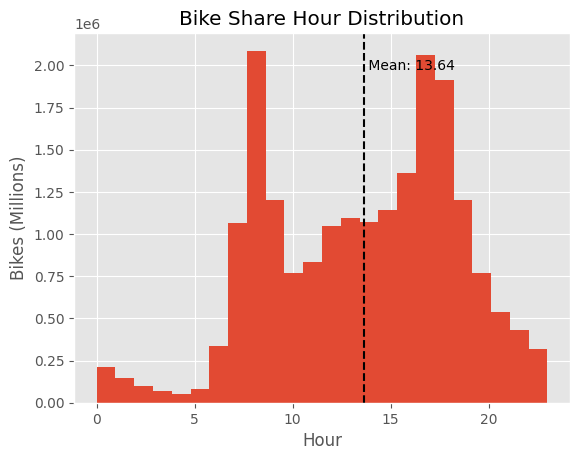

In [9]:
# Begin Analysis by looking at a summary of critical numeric columns

# Looking for the hour of day that prompts the highest bikes sales
print(df_repeated['hour'].describe())
ax = df_repeated['hour'].plot(kind='hist',bins=24,title='Bike Share Hour Distribution')
ax.set_xlabel('Hour')
ax.set_ylabel('Bikes (Millions)')

# Adding mean line to graph
mean = df_repeated['hour'].mean()
ax.axvline(mean, color='k', linestyle='--')
ax.text(mean, ax.get_ylim()[1] * 0.9, f' Mean: {mean:.2f}', color='k', ha='left')

plt.show()

count   19905972.0000
mean          14.5244
std            5.8597
min           -1.5000
25%           10.0000
50%           14.5000
75%           19.0000
max           34.0000
Name: temp_real_C, dtype: float64


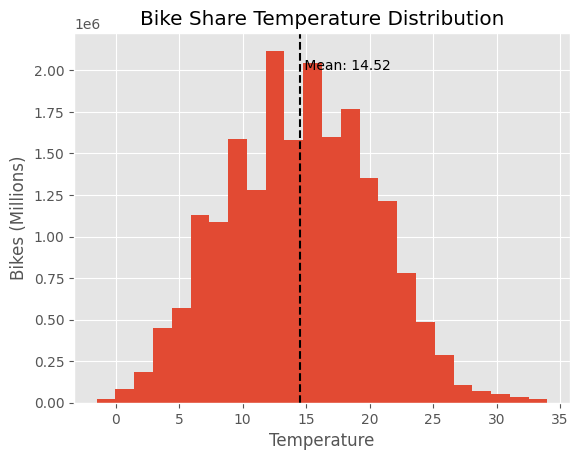

In [10]:
# Determining optimal temperature for bike sales
print(df_repeated['temp_real_C'].describe())
ax = df_repeated['temp_real_C'].plot(kind='hist',bins=24,title='Bike Share Temperature Distribution')
ax.set_xlabel('Temperature')
ax.set_ylabel('Bikes (Millions)')

# Adding mean line to graph
mean = df_repeated['temp_real_C'].mean()
ax.axvline(mean, color='k', linestyle='--')
ax.text(mean, ax.get_ylim()[1] * 0.9, f' Mean: {mean:.2f}', color='k', ha='left')

plt.show()

count   19905972.0000
mean          66.0359
std           15.3123
min           20.5000
25%           54.5000
50%           67.0000
75%           78.0000
max          100.0000
Name: humidity_percent, dtype: float64


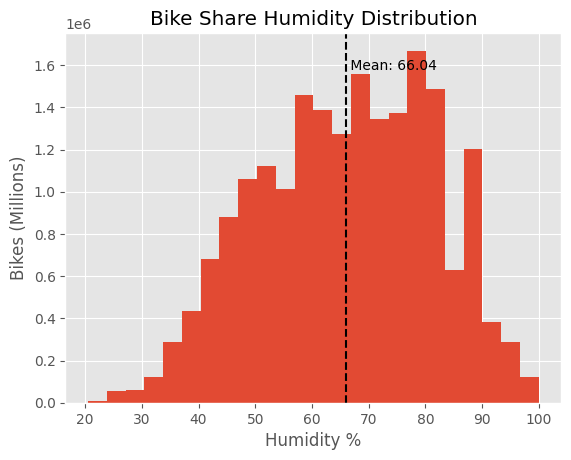

In [11]:
# Determining optimal humidity for bike sales
print(df_repeated['humidity_percent'].describe())
ax = df_repeated['humidity_percent'].plot(kind='hist',bins=24,title='Bike Share Humidity Distribution')
ax.set_xlabel('Humidity %')
ax.set_ylabel('Bikes (Millions)')

# Adding mean line to graph
mean = df_repeated['humidity_percent'].mean()
ax.axvline(mean, color='k', linestyle='--')
ax.text(mean, ax.get_ylim()[1] * 0.9, f' Mean: {mean:.2f}', color='k', ha='left')

plt.show()

count   19905972.0000
mean          16.7845
std            7.5374
min            0.0000
25%           11.0000
50%           16.0000
75%           21.5000
max           56.5000
Name: wind_speed_kph, dtype: float64


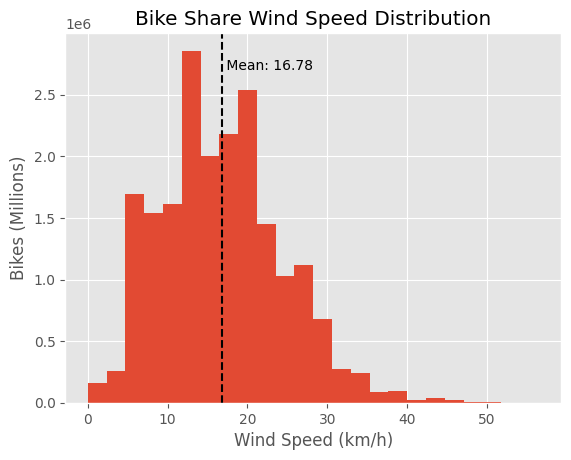

In [12]:
# Determining optimal wind speeds for higher bike sales
print(df_repeated['wind_speed_kph'].describe())
ax = df_repeated['wind_speed_kph'].plot(kind='hist',bins=24,title='Bike Share Wind Speed Distribution')
ax.set_xlabel('Wind Speed (km/h)')
ax.set_ylabel('Bikes (Millions)')

# Adding mean line to graph
mean = df_repeated['wind_speed_kph'].mean()
ax.axvline(mean, color='k', linestyle='--')
ax.text(mean, ax.get_ylim()[1] * 0.9, f' Mean: {mean:.2f}', color='k', ha='left')

plt.show()

To get a more concise picture of which metrics may contribute the most to bike sales, I have decided to check the correlation values of each column. The correlation value describes the potential of any alteration to one column to thereby alter another column in the dataset, for example, to check if increases or decreases in humidity increase/decrease bike sales. Closer values to positive or negative 1 are key indicators that a column is highly correlated and should prompt further investigation.

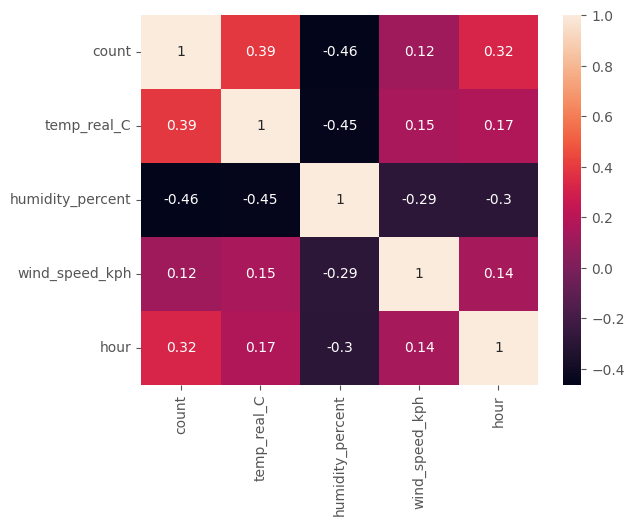

In [13]:
df_corr = df[['count','temp_real_C','humidity_percent','wind_speed_kph','hour']].dropna().corr()
sns.heatmap(df_corr,annot=True)
plt.show()

It appears that no numeric correlation contains enough statistical siginificance to warrant any further investigation. After looking at some statistics for some of the numeric metrics, I now want to gather a visual for bike sales over time and determine any trends in time that would offer insight into driving sales:

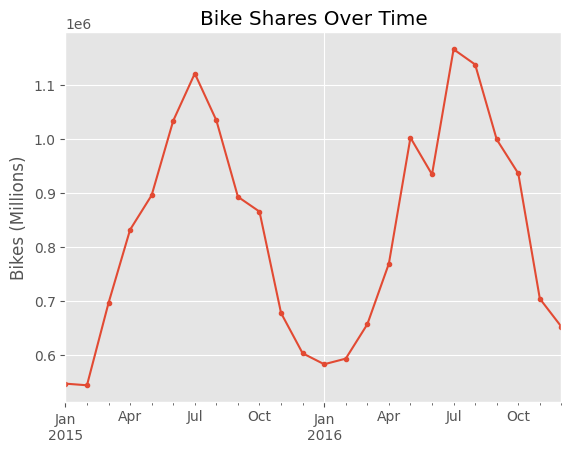

In [14]:
# Verify correct data types of necessary columns
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['count'] = pd.to_numeric(df['count'])

# Drop any potential missing values from the de-aggregarion process
df.dropna(subset=['count'], inplace=True)

# Set new index to timestamp column to allow data to be regrouped by month to clean the graph
df.set_index('timestamp', inplace=True, drop=False)

# Resample graph by month instead of datetime to clean up a lot of clutter and create a clean plot
monthly_data = df.resample('ME')['count'].sum().to_frame()
monthly_data.reset_index(inplace=True)

# Filter data to before 2017
monthly_data = monthly_data[monthly_data['timestamp'] < '2017-01-01']

# Plot bike sales against time
ax = monthly_data.plot(x='timestamp',y='count',kind='line',style='.-',title='Bike Shares Over Time',legend=False)
ax.set_xlabel('')
ax.set_ylabel('Bikes (Millions)')
plt.show()

While this visual offers insight into the best times of the year for bike sales, and paints the picture of a cyclic sales pattern, I would like to drill down through different time windows such as month and day of the week to determine the best times at different time windows.

In [15]:
# This function is not too important, and serves the purpose of making the upcoming visuals easier to interpret with automatically adjusting data labels
def shortnum(num):
    if num>=1000000:
        return f'{num/1000000:.1f}M'
    elif num>=1000:
        return f'{num/1000:.1f}K'
    else:
        return num.asstring()

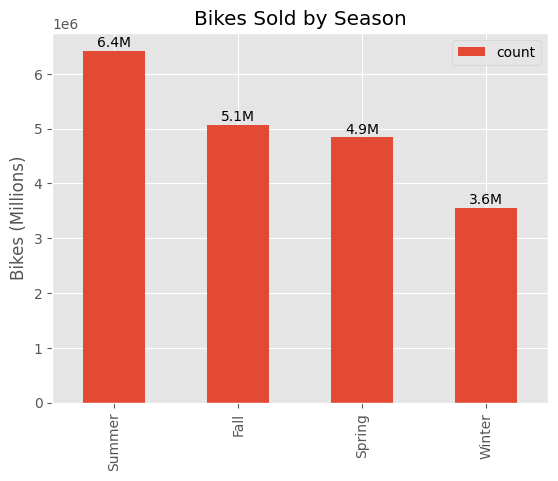

In [16]:
# Firstly looking at seasonal sales

# Create a new dataframe aggregated by season
df_season = df_repeated.groupby('season')[['count']].count().reset_index().sort_values(by='count', ascending=False)

# Plot the new dataframe
ax = df_season.plot(x='season',y='count',kind='bar',title='Bikes Sold by Season')

# Apply data labels
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height()+10000, shortnum(i.get_height()), ha='center', va='bottom', fontsize=10)

ax.set_xlabel('')
ax.set_ylabel('Bikes (Millions)')
plt.show()

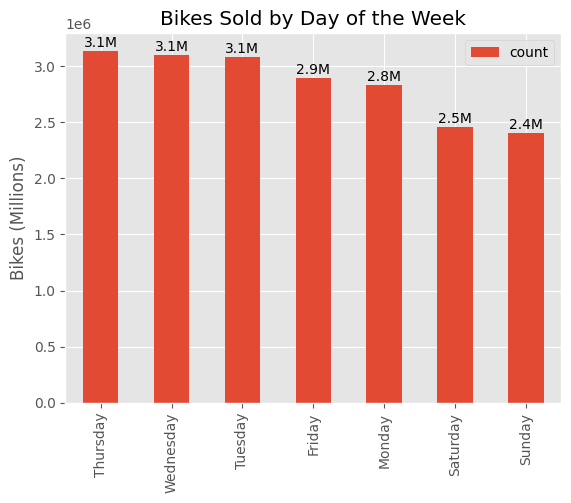

In [17]:
# Looking at sales broken up by day of the week

# Create a new dataframe aggregated by day of the week
df_dow = df_repeated.groupby('day_of_week')[['count']].count().reset_index().sort_values(by='count', ascending=False)

# Plot the new dataframe
ax = df_dow.plot(x='day_of_week',y='count',kind='bar',title='Bikes Sold by Day of the Week')

# Apply data labels
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height()+10000, shortnum(i.get_height()), ha='center', va='bottom', fontsize=10)

ax.set_xlabel('')
ax.set_ylabel('Bikes (Millions)')
plt.show()

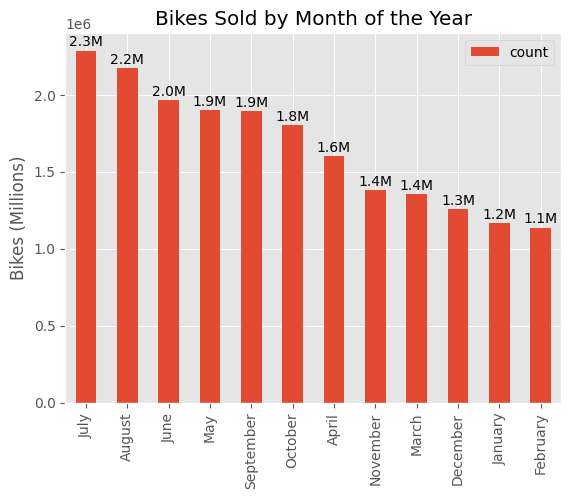

In [18]:
# Looking at sales broken up by month of the year

# Create a new dataframe aggregated by month of the year
df_moy = df_repeated.groupby('month_of_year')[['count']].count().reset_index().sort_values(by='count', ascending=False)

# Plot the new dataframe
ax = df_moy.plot(x='month_of_year',y='count',kind='bar',title='Bikes Sold by Month of the Year')

# Apply data labels
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height()+10000, shortnum(i.get_height()), ha='center', va='bottom', fontsize=10)

ax.set_xlabel('')
ax.set_ylabel('Bikes (Millions)')
plt.show()

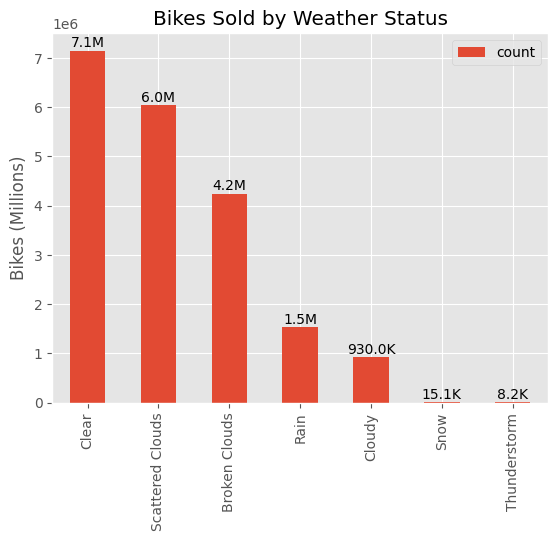

In [19]:
# As an added bonus, I have decided to examine sales by different weather statuses

# Create a new dataframe aggregated by weather status
df_weather = df_repeated.groupby('weather')[['count']].count().reset_index().sort_values(by='count', ascending=False)

# Plot the new dataframe
ax = df_weather.plot(x='weather',y='count',kind='bar',title='Bikes Sold by Weather Status')

# Apply data labels
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height()+10000, shortnum(i.get_height()), ha='center', va='bottom', fontsize=10)

ax.set_xlabel('')
ax.set_ylabel('Bikes (Millions)')
plt.show()